In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL import Image
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import models

from tqdm import tqdm
import timm

from datetime import datetime

/home/hpclab01/jupyter_server_test/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load the different bird species from the `class_names.npy` file and then the attributes from `attributes.npy` which has for every class 312 features that are explained by the file `attributes.txt`.

In [2]:
images_df = pd.read_csv("data/train_images.csv")
images_df["image_path"] = images_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))
images_df.head()

,image_path,label
0,data/train_images/1.jpg,1
1,data/train_images/2.jpg,1
2,data/train_images/3.jpg,1
3,data/train_images/4.jpg,1
4,data/train_images/5.jpg,1


In [3]:
bird_classes = np.load("data/class_names.npy", allow_pickle=True).item()
attributes = np.load('data/attributes.npy')
attributes.shape

(200, 312)

In [4]:
with open("data/attributes.txt", "r") as f:
    attribute_names = [line.strip() for line in f.readlines()]
attribute_names[:5]

['1 has_bill_shape::curved_(up_or_down)',
 '2 has_bill_shape::dagger',
 '3 has_bill_shape::hooked',
 '4 has_bill_shape::needle',
 '5 has_bill_shape::hooked_seabird']

Unify the attributes files to map for every bird species they're features

Create a data frame `birds_df` with the class_id and the 312 attrbiutes of each bird class. Then merge it with the class name of each bird.

In [5]:
class_attributes = {}
for class_id in range(attributes.shape[0]):
    class_attributes[class_id + 1] = {
        attribute_names[i]: attributes[class_id, i] for i in range(len(attribute_names))
    }

birds_df = pd.DataFrame.from_dict(class_attributes, orient="index")
birds_df.index.name = "class_id"
birds_df.reset_index(inplace=True)
birds_df.head()

,class_id,1 has_bill_shape::curved_(up_or_down),2 has_bill_shape::dagger,3 has_bill_shape::hooked,4 has_bill_shape::needle,5 has_bill_shape::hooked_seabird,6 has_bill_shape::spatulate,7 has_bill_shape::all-purpose,8 has_bill_shape::cone,9 has_bill_shape::specialized,...,303 has_crown_color::pink,304 has_crown_color::orange,305 has_crown_color::black,306 has_crown_color::white,307 has_crown_color::red,308 has_crown_color::buff,309 has_wing_pattern::solid,310 has_wing_pattern::spotted,311 has_wing_pattern::striped,312 has_wing_pattern::multi-colored
0,1,0.010638,0.010638,0.007092,0.003546,0.138299,0.065603,0.000000,0.005319,0.000000,...,0.000000,0.005439,0.005439,0.228446,0.000000,0.000000,0.186020,0.009186,0.025262,0.020669
1,2,0.000000,0.011332,0.009444,0.000000,0.202095,0.041552,0.015110,0.005666,0.000000,...,0.006291,0.000000,0.111144,0.008388,0.000000,0.046135,0.202572,0.002665,0.021323,0.058639
2,3,0.000000,0.000000,0.007425,0.000000,0.002475,0.000000,0.000000,0.074247,0.146020,...,0.000000,0.000000,0.190411,0.012555,0.000000,0.010462,0.203609,0.000000,0.008853,0.017705
3,4,0.000000,0.000000,0.003861,0.000000,0.003861,0.013514,0.005792,0.073360,0.138998,...,0.004885,0.000000,0.190531,0.000000,0.000000,0.000000,0.152750,0.006840,0.036478,0.043317
4,5,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.102458,0.070177,0.000000,...,0.000000,0.000000,0.204036,0.002458,0.002458,0.000000,0.031640,0.002751,0.015132,0.158200


Create dataframe mapping bird names with their id

In [6]:
classes = pd.DataFrame.from_dict(bird_classes, orient="index").reset_index()
classes.columns = ["class", "id"]
classes.head()

,class,id
0,001.Black_footed_Albatross,1
1,002.Laysan_Albatross,2
2,003.Sooty_Albatross,3
3,004.Groove_billed_Ani,4
4,005.Crested_Auklet,5


Merge class name with the attributes

In [7]:
birds_df = birds_df.merge(classes, left_on="class_id", right_on="id")
birds_df = birds_df.drop(columns=["id"])

# Reorder columns to have class_id and class first
cols = ["class_id", "class"] + [c for c in birds_df.columns if c not in ["class_id", "class"]]
birds_df = birds_df[cols]
birds_df.head()

,class_id,class,1 has_bill_shape::curved_(up_or_down),2 has_bill_shape::dagger,3 has_bill_shape::hooked,4 has_bill_shape::needle,5 has_bill_shape::hooked_seabird,6 has_bill_shape::spatulate,7 has_bill_shape::all-purpose,8 has_bill_shape::cone,...,303 has_crown_color::pink,304 has_crown_color::orange,305 has_crown_color::black,306 has_crown_color::white,307 has_crown_color::red,308 has_crown_color::buff,309 has_wing_pattern::solid,310 has_wing_pattern::spotted,311 has_wing_pattern::striped,312 has_wing_pattern::multi-colored
0,1,001.Black_footed_Albatross,0.010638,0.010638,0.007092,0.003546,0.138299,0.065603,0.000000,0.005319,...,0.000000,0.005439,0.005439,0.228446,0.000000,0.000000,0.186020,0.009186,0.025262,0.020669
1,2,002.Laysan_Albatross,0.000000,0.011332,0.009444,0.000000,0.202095,0.041552,0.015110,0.005666,...,0.006291,0.000000,0.111144,0.008388,0.000000,0.046135,0.202572,0.002665,0.021323,0.058639
2,3,003.Sooty_Albatross,0.000000,0.000000,0.007425,0.000000,0.002475,0.000000,0.000000,0.074247,...,0.000000,0.000000,0.190411,0.012555,0.000000,0.010462,0.203609,0.000000,0.008853,0.017705
3,4,004.Groove_billed_Ani,0.000000,0.000000,0.003861,0.000000,0.003861,0.013514,0.005792,0.073360,...,0.004885,0.000000,0.190531,0.000000,0.000000,0.000000,0.152750,0.006840,0.036478,0.043317
4,5,005.Crested_Auklet,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.102458,0.070177,...,0.000000,0.000000,0.204036,0.002458,0.002458,0.000000,0.031640,0.002751,0.015132,0.158200


### Define Device (GPU or CPU)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Load training metadata and create train/validation split
We create a stratified train/validation split so that all 200 classes are represented proportionally in both sets.  
This split will be used to train the CNN on `train_images` and evaluate it on `val_images`.


In [9]:
train_images, val_images = train_test_split(
    images_df,
    test_size=0.2,
    stratify=images_df["label"],
    random_state=42
)
len(train_images), len(val_images)

(3140, 786)

In [10]:
train_images.head()

,image_path,label
1249,data/train_images/1250.jpg,42
3882,data/train_images/3883.jpg,193
686,data/train_images/687.jpg,23
1452,data/train_images/1453.jpg,49
2357,data/train_images/2358.jpg,85


### Define Image Transformations for Training and Validation

Before training a CNN, all images need to be preprocessed in a consistent way.  
Here, we define two sets of transformations:

**Training transforms**
- **Resize to 224×224:** ResNet models expect fixed-size input.
- **Random horizontal flip:** A simple data augmentation step to help the model generalize.
- **Convert to tensor:** Converts the image to a PyTorch tensor with values in `[0,1]`.
- **Normalize with ImageNet statistics:** Since ResNet18 was pretrained on ImageNet, the same normalization must be applied for best performance.

**Validation transforms**
- Same as above but **without augmentation**, to ensure a stable and deterministic evaluation.

These transforms prepare raw images so they can be passed into the CNN during training and validation.


In [11]:
# # image transforms (basic baseline)
# train_transform = T.Compose([
#     T.Resize((224, 224)),
#     T.RandomHorizontalFlip(),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
# ])

# val_transform = T.Compose([
#     T.Resize((224, 224)),
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225]),
# ])

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224, scale=(0.7, 1.0)),  # More aggressive
    
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(20),  
    T.RandomAffine(
        degrees=0,
        translate=(0.15, 0.15),
        scale=(0.85, 1.15)
    ),
    
    T.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.15
    ),
    
    T.RandomGrayscale(p=0.1),
    
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
    
    T.RandomErasing(p=0.3, scale=(0.02, 0.2))
])

val_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


### Create a custom PyTorch Dataset for bird images

Here we define a `BirdsDataset` class that:
- Reads the image path and label from the DataFrame rows.
- Loads each image with PIL.
- Applies the appropriate transform (train or validation).
- Converts labels from 1–200 to 0–199 so they work with `nn.CrossEntropyLoss`.

This Dataset will be used together with a DataLoader to efficiently feed batches to the CNN.

In [12]:
class BirdsDataset(Dataset):
    def __init__(self, df, transform=None, use_attributes=False, is_test=False):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.use_attributes = use_attributes
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        if self.is_test:
            return img
        else:
            label = int(row["label"]) - 1  # for training set also return the label in 0-199
            return img, label

### Wrap Datasets in DataLoaders

Now we create `DataLoader` objects for the training and validation sets.  
DataLoaders handle:
- Shuffling (for training),
- Batching,
- Parallel loading of images (with `num_workers`).

These will be used directly in the training and evaluation loops.


In [13]:
train_dataset = BirdsDataset(train_images, transform=train_transform)
val_dataset = BirdsDataset(val_images,   transform=val_transform)

batch_size = 64

if device == 'cpu': 
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # model sees data in random order
        num_workers=0, # parallel processing
        pin_memory=True # faster data transfer to GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
else:
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # model sees data in random order
        num_workers=2, # parallel processing
        pin_memory=True # faster data transfer to GPU
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

### Define training and validation loops

Here we implement two functions:

- `train_one_epoch`: runs one epoch over the training set, updates weights, and tracks loss and accuracy.
- `evaluate`: runs one full pass over the validation set without gradient updates, and reports loss and accuracy.

These utilities keep the main training loop clean and readable, and allow easy reuse later.

In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Val", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

### 🛑 EarlyStopping Callback

The `EarlyStopping` class is a training utility that monitors validation loss and stops training when the model stops improving.  
This helps prevent **overfitting** and saves training time.

#### 🔍 How it works
- **patience**: How many epochs to wait for improvement before stopping.
- **min_delta**: Minimum decrease in validation loss that counts as an improvement.
- **best_score**: Tracks the best (lowest) validation loss seen so far.
- **counter**: Counts how many consecutive epochs had no improvement.
- **early_stop**: Becomes `True` when early stopping should trigger.

#### 📉 When validation loss improves:
- The model’s weights are saved to `checkpoint.pt`.
- The counter resets to 0.

#### 📈 When validation loss does *not* improve:
- The counter increases.
- If the counter reaches `patience`, training will stop early.

This class is typically used during training loops to prevent unnecessary epochs once the model stops learning.

In [15]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self._update(val_loss)

        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self._update(val_loss)
            self.counter = 0

    def _update(self, val_loss):
        if self.verbose:
            print(
                f'Validation loss decreased '
                f'({self.val_loss_min:.6f} → {val_loss:.6f}).'
            )
        self.val_loss_min = val_loss


### To plot training vs accuracy per epoch

In [16]:
def train_val_plot(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Initialize Test Dataset

In [17]:
def initialize_test_dataset(test_path, test_transform): 
    test_df = pd.read_csv(test_path)
    test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))
    
    test_dataset = BirdsDataset(test_df, transform=test_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    return test_loader

#### Initialize predictions and cnn_models folder

In [18]:
os.makedirs("predictions", exist_ok=True)
os.makedirs("cnn_models", exist_ok=True)

### Define prediction using CNN model

In [19]:
def prediction(model, model_name, test_loader, test_path):
    all_preds = []
    
    with torch.no_grad():
        for images in tqdm(test_loader):
            images = images.to(device)
    
            logits = model(images)          # (B, 200)
            preds = torch.argmax(logits, 1) # 0–199
    
            preds = preds.cpu().numpy() + 1 # 1–200 (CUB format)
            all_preds.extend(preds)
            
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    file_path = f"predictions/{model_name}_{timestamp}.csv"
    
    test_df["label"] = all_preds
    test_df[["id", "label"]].to_csv(file_path, index=False)
    
    print(f"Saved predictions to {file_path}")

## Define baseline models

## SimpleCNN Architecture Overview

This `SimpleCNN` model is a custom convolutional neural network designed for fine-grained classification of **200 bird species**.  
It consists of four convolutional blocks that progressively extract deeper visual features, followed by global average pooling and two fully-connected layers for classification.

---

### 🔍 **Architecture Breakdown**

#### **1. Convolutional Feature Extractor (4 Blocks)**  
Each conv block contains:
- A **3×3 convolution**
- **Batch Normalization** (stabilizes training)
- **ReLU activation**
- **2×2 Max Pooling** (halves spatial resolution)

Feature map progression:

| Block | Input Channels | Output Channels | Resolution Change |
|-------|----------------|------------------|-------------------|
| Conv1 | 3 → 32         | 224×224 → 112×112 |
| Conv2 | 32 → 64        | 112×112 → 56×56  |
| Conv3 | 64 → 128       | 56×56 → 28×28    |
| Conv4 | 128 → 256      | 28×28 → 14×14    |

This deepening structure allows the model to learn:
- low-level edges and textures (block 1–2)  
- mid-level shapes and patterns (block 3)  
- high-level semantic features (block 4)

---

### **2. Adaptive Average Pooling**
The 14×14 output of the last conv block is reduced to **4×4** using:

```python
nn.AdaptiveAvgPool2d((4, 4))


In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, feat_dim=512):
        super(SimpleCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # 224 → 112
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # 112 → 56
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # 56 → 28
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)    # 28 → 14
        )

        # 14×14 → 4×4
        self.gap = nn.AdaptiveAvgPool2d((4, 4))      # 14 → 4

        # final feature dimension = 512
        self.fc_img = nn.Linear(256 * 4 * 4, feat_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.gap(x)                  # (B, 256, 4, 4)
        x = torch.flatten(x, 1)          # (B, 256*4*4)
        x = F.relu(self.fc_img(x))       # (B, feat_dim)
        x = self.dropout(x)
        return x

### 1st approach: Cosine Classifier Head

In [21]:
class CosineClassifier(nn.Module):
    def __init__(self, num_classes, feat_dim, scale=10.0):
        super(CosineClassifier, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.scale = scale

        # one weight vector per class
        self.weight = nn.Parameter(torch.randn(num_classes, feat_dim))
        nn.init.xavier_normal_(self.weight)  # sensible init

    def forward(self, feats):
        # feats: (B, feat_dim)
        feats_n = F.normalize(feats, dim=1)          # (B, D)
        weight_n = F.normalize(self.weight, dim=1)   # (C, D)

        # cosine similarity: (B, D) @ (D, C) = (B, C)
        logits = self.scale * feats_n @ weight_n.t()
        return logits

#### Combine the feature vector of CNN with the Cosine head to predict

In [22]:
class CNNWithCosineHead(nn.Module):
    def __init__(self, num_classes=200, feat_dim=512, scale=10.0):
        super(CNNWithCosineHead, self).__init__()
        self.backbone = SimpleCNN(feat_dim=feat_dim)
        self.head = CosineClassifier(num_classes=num_classes, feat_dim=feat_dim, scale=scale)
    def forward(self, x):
        feats = self.backbone(x)     # (B, feat_dim)
        logits = self.head(feats)    # (B, num_classes)
        return logits

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNWithCosineHead(num_classes=200, feat_dim=512, scale=10.0).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

#### Train the CNN baseline model and monitor accuracy

We run the training for a few epochs.  
For each epoch, we log:
- Training loss and accuracy
- Validation loss and accuracy

We also keep track of the best validation accuracy and save the model weights whenever a new best score is reached.  
This gives me a first baseline performance for the bird classification task.


In [38]:
# CAREFUL TO NOT OVERWRITE
model_name = "2cnn_cosine_similarity.pt"

In [ ]:
model_dir = "cnn_models"
model_path = os.path.join(model_dir, model_name)

# Scheduler: reduce LR when val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

early_stopping = EarlyStopping(patience=10, min_delta=0.0, verbose=True)
train_losses, val_losses, train_accs, val_accs = [], [], [], []
num_epochs = 250

best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # save best model by val acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")

    # early stopping on val_loss
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break



Epoch 1/250


  Train | loss: 5.3500, acc: 0.0064
  Val   | loss: 5.2111, acc: 0.0127
New best model saved with val_acc = 0.0127
Validation loss decreased (inf → 5.211050).

Epoch 2/250


Train:  56%|█████▌    | 28/50 [00:04<00:03,  6.81it/s]

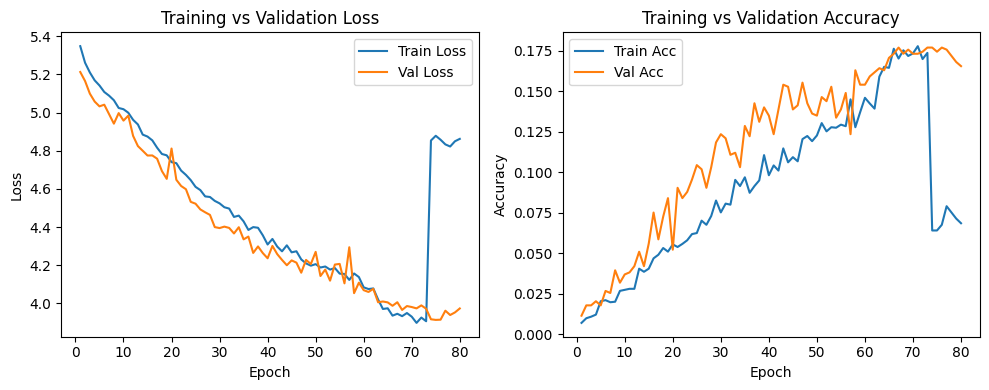

In [33]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

#### Prediction

In [27]:
# initialize model
model = CNNWithCosineHead(num_classes=200, feat_dim=512, scale=10.0).to(device)
model.load_state_dict(torch.load("cnn_models/cnn_cosine_similarity.pt", map_location=device))
model.eval()

CNNWithCosineHead(
  (backbone): SimpleCNN(
    (conv_block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block4): Sequentia

In [29]:
test_dataset_path = "data/test_images_path.csv"
test_loader = initialize_test_dataset(test_dataset_path, test_transform=val_transform)
prediction(model, model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:02<00:00, 21.74it/s]


NameError: name 'test_df' is not defined

### 2nd Approach: Using different head classifiers

In [152]:
class MLPClassifier(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, feats):
        return self.mlp(feats)

In [153]:
class CNNWithMLPHead(nn.Module):
    def __init__(self, num_classes=200, feat_dim=512):
        super(CNNWithMLPHead, self).__init__()
        self.backbone = SimpleCNN(feat_dim=feat_dim)
        self.head = MLPClassifier(feat_dim=feat_dim, num_classes=num_classes)

    def forward(self, x):
        feats = self.backbone(x)     # CNN → features
        logits = self.head(feats)    # MLP → logits over classes
        return logits

In [154]:
model = CNNWithMLPHead(num_classes=200, feat_dim=512).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [156]:
model_name = "test_cnn_mlp.pt"
model_dir = "cnn_models"
model_path = os.path.join(model_dir, model_name)

# Scheduler: reduce LR when val_loss plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

early_stopping = EarlyStopping(patience=5, min_delta=0.0, verbose=True)

num_epochs = 100

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    scheduler.step(val_loss)

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # save best model by val acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")

    # early stopping on val_loss
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break



Epoch 1/3


  Train | loss: 5.1271, acc: 0.0178
  Val   | loss: 5.0958, acc: 0.0216
New best model saved with val_acc = 0.0216
Validation loss decreased (inf → 5.095779).

Epoch 2/3


  Train | loss: 5.1206, acc: 0.0185
  Val   | loss: 5.0411, acc: 0.0178
Validation loss decreased (5.095779 → 5.041124).

Epoch 3/3


  Train | loss: 5.0888, acc: 0.0143
  Val   | loss: 5.0487, acc: 0.0267
New best model saved with val_acc = 0.0267
EarlyStopping counter: 1/5


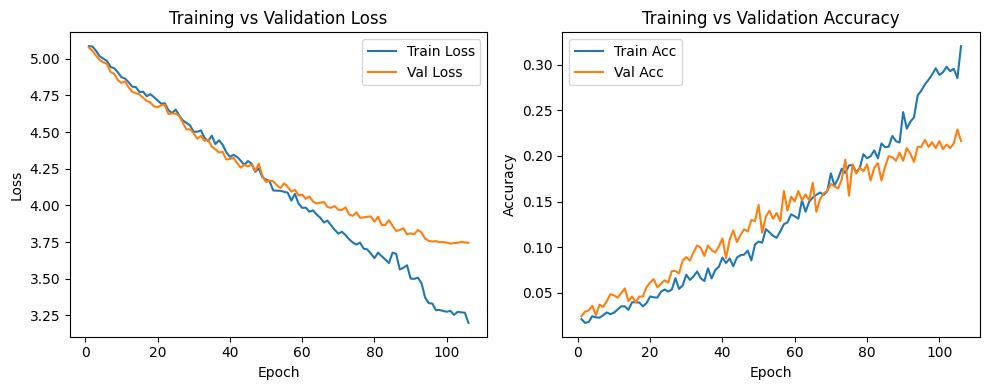

In [87]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

#### Prediction

In [88]:
# initialize model
model = CNNWithMLPHead(num_classes=200, feat_dim=512).to(device)
model.load_state_dict(torch.load("best_cnn_cosine2.pt", map_location=device))
model.eval()

CNNWithMLPHead(
  (backbone): SimpleCNN(
    (conv_block1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block4): Sequential(


In [157]:
test_dataset_path = "data/test_images_path.csv"
test_loader = initialize_test_dataset(test_path, test_transform=val_transform)
prediction(model, model_name, test_loader, test_dataset_path)

100%|██████████| 63/63 [00:02<00:00, 24.42it/s]

Saved predictions to predictions/test_cnn_mlp.pt_2025-12-09_15-50.csv


# END OF CUSTOM CNN ARCHITECTURE

# BASELINE MODELS

### Define a baseline pretrained model (ResNet18)

As a strong baseline, we use a pretrained `ResNet18` from `torchvision.models`:
- We load ImageNet-pretrained weights.
- We replace the final fully-connected layer so it outputs 200 logits (one per bird class).
- The rest of the network acts as a feature extractor.

This gives a solid starting point for accuracy without heavy custom architecture work.


In [19]:
# Load pretrained ResNet18
weights = models.ResNet18_Weights.IMAGENET1K_V1
ResNet_model = models.resnet18(weights=weights)

# Replace the final layer to match 200 classes
num_features = ResNet_model.fc.in_features
ResNet_model.fc = nn.Linear(num_features, 200)

ResNet_model = ResNet_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
ResNet_optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=1e-4)

In [20]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}") 

    train_loss, train_acc = train_one_epoch(
        ResNet_model, train_loader, ResNet_optimizer, criterion, device
    )

    # ---- validation ----
    val_loss, val_acc = evaluate(
        ResNet_model, val_loader, criterion, device
    )

    # ---- logging ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    # ---- early stopping ----
    early_stopping(val_loss, ResNet_model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # ---- best model saving ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(ResNet_model.state_dict(), "best_resnet18.pt")
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")


Epoch 1/60


Validation loss decreased (inf → 4.531248). Saving model...
  Train | loss: 5.1092, acc: 0.0389
  Val   | loss: 4.5312, acc: 0.1412
New best model saved with val_acc = 0.1412

Epoch 2/60


Validation loss decreased (4.531248 → 3.965867). Saving model...
  Train | loss: 3.8221, acc: 0.3936
  Val   | loss: 3.9659, acc: 0.2583
New best model saved with val_acc = 0.2583

Epoch 3/60


Validation loss decreased (3.965867 → 3.549058). Saving model...
  Train | loss: 2.9988, acc: 0.6226
  Val   | loss: 3.5491, acc: 0.3588
New best model saved with val_acc = 0.3588

Epoch 4/60


Validation loss decreased (3.549058 → 3.317029). Saving model...
  Train | loss: 2.3471, acc: 0.7704
  Val   | loss: 3.3170, acc: 0.3919
New best model saved with val_acc = 0.3919

Epoch 5/60


Validation loss decreased (3.317029 → 3.094933). Saving model...
  Train | loss: 1.7988, acc: 0.8729
  Val   | loss: 3.0949, acc: 0.4326
New best model saved with val_acc = 0.4326

Epoch 6/60


Validation loss decreased (3.094933 → 3.016934). Saving model...
  Train | loss: 1.3409, acc: 0.9449
  Val   | loss: 3.0169, acc: 0.4517
New best model saved with val_acc = 0.4517

Epoch 7/60


Validation loss decreased (3.016934 → 2.924242). Saving model...
  Train | loss: 0.9788, acc: 0.9809
  Val   | loss: 2.9242, acc: 0.4682
New best model saved with val_acc = 0.4682

Epoch 8/60


Validation loss decreased (2.924242 → 2.843780). Saving model...
  Train | loss: 0.6899, acc: 0.9939
  Val   | loss: 2.8438, acc: 0.4733
New best model saved with val_acc = 0.4733

Epoch 9/60


Validation loss decreased (2.843780 → 2.819147). Saving model...
  Train | loss: 0.4729, acc: 0.9981
  Val   | loss: 2.8191, acc: 0.4669

Epoch 10/60


Validation loss decreased (2.819147 → 2.735597). Saving model...
  Train | loss: 0.3263, acc: 1.0000
  Val   | loss: 2.7356, acc: 0.4733

Epoch 11/60


KeyboardInterrupt: 

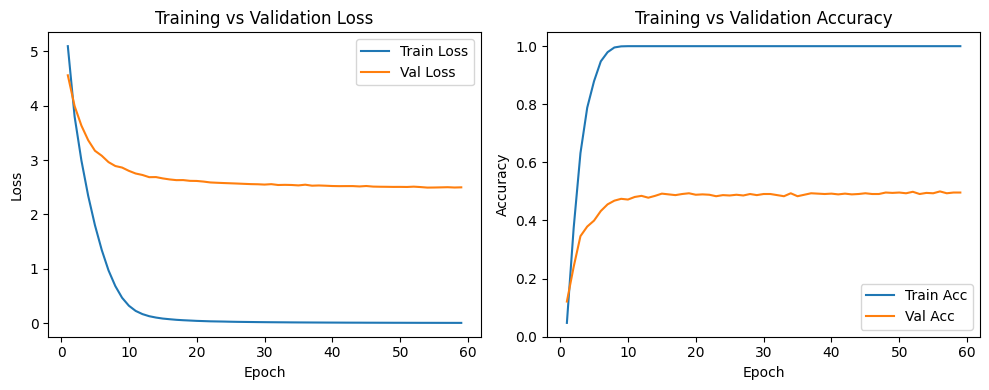

In [60]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### Predict labels

In [63]:
ResNet_model = models.resnet18()
num_features = ResNet_model.fc.in_features
ResNet_model.fc = nn.Linear(num_features, 200)
ResNet_model.load_state_dict(torch.load("best_resnet18.pt", map_location=device))
ResNet_model = ResNet_model.to(device)
ResNet_model.eval()

In [64]:
test_df = pd.read_csv("data/test_images_path.csv")
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/"))) # add /data to path

# Dataset and loader
test_dataset = BirdsDataset(test_df, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ------------------- Predict -------------------
predictions = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        outputs = ResNet_model(imgs)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

# Convert 0–199 → 1–200
test_df["label"] = [p + 1 for p in predictions]
test_df = test_df[['id','label']]
test_df.to_csv("resnet_18.csv", index=False)
print("Saved submission.csv!")

Saved submission.csv!


### Define a baseline CNN model (ResNet50) 

[https://huggingface.co/microsoft/resnet-50]

As a strong baseline, we use a pretrained `ResNet50` from `hugging face`:
- We load ImageNet-pretrained weights.
- We replace the final fully-connected layer so it outputs 200 logits (one per bird class).
- The rest of the network acts as a feature extractor.

This gives a solid starting point for accuracy without heavy custom architecture work.


### Try ResNet 50

In [21]:
# Load timm ResNet50 pretrained on ImageNet-1K
ResNet_model = timm.create_model("resnet50.a1_in1k", pretrained=True)

# Replace classifier for 200 classes
num_features = ResNet_model.get_classifier().in_features
ResNet_model.fc = nn.Linear(num_features, 200)
ResNet_model = ResNet_model.to(device)

criterion = nn.CrossEntropyLoss()

In [22]:
# Freeze everything
for param in ResNet_model.parameters():
    param.requires_grad = False

# Unfreeze last layer for the first epochs
for param in ResNet_model.fc.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, ResNet_model.parameters()), lr=1e-4, weight_decay=1e-4)

# optimizer = torch.optim.Adam(ResNet_model.parameters(), lr=1e-4)

### Train the ResNet50 baseline model and monitor accuracy

In [23]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    
    # Unfreeze network after 3 epochs
    if epoch == 4:
        print("Unfreezing entire ResNet50")
        for param in ResNet_model.parameters():
            param.requires_grad = True

        # When you unfreeze, RECREATE optimizer to include all params
        optimizer = torch.optim.AdamW(
            ResNet_model.parameters(),
            lr=1e-4,          # OR something smaller: 5e-5
            weight_decay=1e-4
        )
        
    train_loss, train_acc = train_one_epoch(
        ResNet_model, train_loader, optimizer, criterion, device
    )

    # ---- validation ----
    val_loss, val_acc = evaluate(
        ResNet_model, val_loader, criterion, device
    )

    # ---- logging ----
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)


    # ---- early stopping ----
    early_stopping(val_loss, ResNet_model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # ---- best model saving ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(ResNet_model.state_dict(), "best_resnet50_2nd_trial.pt")
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")



Epoch 1/60


Validation loss decreased (inf → 5.247510). Saving model...
  Train | loss: 5.2749, acc: 0.0124
  Val   | loss: 5.2475, acc: 0.0191
New best model saved with val_acc = 0.0191

Epoch 2/60


Validation loss decreased (5.247510 → 5.153457). Saving model...
  Train | loss: 5.1631, acc: 0.0443
  Val   | loss: 5.1535, acc: 0.0318
New best model saved with val_acc = 0.0318

Epoch 3/60


Validation loss decreased (5.153457 → 5.046653). Saving model...
  Train | loss: 5.0332, acc: 0.0946
  Val   | loss: 5.0467, acc: 0.0496
New best model saved with val_acc = 0.0496

Epoch 4/60
Unfreezing entire ResNet50


Validation loss decreased (5.046653 → 4.906895). Saving model...
  Train | loss: 4.8826, acc: 0.1357
  Val   | loss: 4.9069, acc: 0.0814
New best model saved with val_acc = 0.0814

Epoch 5/60


Validation loss decreased (4.906895 → 4.716119). Saving model...
  Train | loss: 4.6731, acc: 0.1994
  Val   | loss: 4.7161, acc: 0.1183
New best model saved with val_acc = 0.1183

Epoch 6/60


Validation loss decreased (4.716119 → 4.478560). Saving model...
  Train | loss: 4.4308, acc: 0.2662
  Val   | loss: 4.4786, acc: 0.1590
New best model saved with val_acc = 0.1590

Epoch 7/60


Validation loss decreased (4.478560 → 4.199512). Saving model...
  Train | loss: 4.1485, acc: 0.3389
  Val   | loss: 4.1995, acc: 0.2061
New best model saved with val_acc = 0.2061

Epoch 8/60


Validation loss decreased (4.199512 → 3.895141). Saving model...
  Train | loss: 3.8328, acc: 0.4111
  Val   | loss: 3.8951, acc: 0.2684
New best model saved with val_acc = 0.2684

Epoch 9/60


Validation loss decreased (3.895141 → 3.578084). Saving model...
  Train | loss: 3.4930, acc: 0.4818
  Val   | loss: 3.5781, acc: 0.3244
New best model saved with val_acc = 0.3244

Epoch 10/60


Validation loss decreased (3.578084 → 3.287386). Saving model...
  Train | loss: 3.1274, acc: 0.5449
  Val   | loss: 3.2874, acc: 0.3626
New best model saved with val_acc = 0.3626

Epoch 11/60


Validation loss decreased (3.287386 → 2.996888). Saving model...
  Train | loss: 2.7726, acc: 0.5847
  Val   | loss: 2.9969, acc: 0.3969
New best model saved with val_acc = 0.3969

Epoch 12/60


Validation loss decreased (2.996888 → 2.763618). Saving model...
  Train | loss: 2.4408, acc: 0.6411
  Val   | loss: 2.7636, acc: 0.4288
New best model saved with val_acc = 0.4288

Epoch 13/60


Validation loss decreased (2.763618 → 2.590445). Saving model...
  Train | loss: 2.1364, acc: 0.6885
  Val   | loss: 2.5904, acc: 0.4644
New best model saved with val_acc = 0.4644

Epoch 14/60


Validation loss decreased (2.590445 → 2.435295). Saving model...
  Train | loss: 1.8764, acc: 0.7318
  Val   | loss: 2.4353, acc: 0.4784
New best model saved with val_acc = 0.4784

Epoch 15/60


Validation loss decreased (2.435295 → 2.279066). Saving model...
  Train | loss: 1.6452, acc: 0.7761
  Val   | loss: 2.2791, acc: 0.5013
New best model saved with val_acc = 0.5013

Epoch 16/60


Validation loss decreased (2.279066 → 2.173730). Saving model...
  Train | loss: 1.4324, acc: 0.8111
  Val   | loss: 2.1737, acc: 0.5140
New best model saved with val_acc = 0.5140

Epoch 17/60


Validation loss decreased (2.173730 → 2.077278). Saving model...
  Train | loss: 1.2441, acc: 0.8481
  Val   | loss: 2.0773, acc: 0.5280
New best model saved with val_acc = 0.5280

Epoch 18/60


Validation loss decreased (2.077278 → 1.987898). Saving model...
  Train | loss: 1.0812, acc: 0.8882
  Val   | loss: 1.9879, acc: 0.5458
New best model saved with val_acc = 0.5458

Epoch 19/60


Validation loss decreased (1.987898 → 1.911107). Saving model...
  Train | loss: 0.9367, acc: 0.9127
  Val   | loss: 1.9111, acc: 0.5509
New best model saved with val_acc = 0.5509

Epoch 20/60


Validation loss decreased (1.911107 → 1.855170). Saving model...
  Train | loss: 0.7956, acc: 0.9401
  Val   | loss: 1.8552, acc: 0.5458

Epoch 21/60


Validation loss decreased (1.855170 → 1.799597). Saving model...
  Train | loss: 0.6685, acc: 0.9586
  Val   | loss: 1.7996, acc: 0.5674
New best model saved with val_acc = 0.5674

Epoch 22/60


Validation loss decreased (1.799597 → 1.770017). Saving model...
  Train | loss: 0.5681, acc: 0.9748
  Val   | loss: 1.7700, acc: 0.5611

Epoch 23/60


Validation loss decreased (1.770017 → 1.724248). Saving model...
  Train | loss: 0.4813, acc: 0.9847
  Val   | loss: 1.7242, acc: 0.5725
New best model saved with val_acc = 0.5725

Epoch 24/60


Validation loss decreased (1.724248 → 1.683321). Saving model...
  Train | loss: 0.4038, acc: 0.9901
  Val   | loss: 1.6833, acc: 0.5725

Epoch 25/60


Validation loss decreased (1.683321 → 1.665643). Saving model...
  Train | loss: 0.3348, acc: 0.9946
  Val   | loss: 1.6656, acc: 0.5802
New best model saved with val_acc = 0.5802

Epoch 26/60


Validation loss decreased (1.665643 → 1.636256). Saving model...
  Train | loss: 0.2841, acc: 0.9959
  Val   | loss: 1.6363, acc: 0.5763

Epoch 27/60


Validation loss decreased (1.636256 → 1.628247). Saving model...
  Train | loss: 0.2376, acc: 0.9971
  Val   | loss: 1.6282, acc: 0.5725

Epoch 28/60


Validation loss decreased (1.628247 → 1.617217). Saving model...
  Train | loss: 0.2020, acc: 0.9981
  Val   | loss: 1.6172, acc: 0.5738

Epoch 29/60


Validation loss decreased (1.617217 → 1.595323). Saving model...
  Train | loss: 0.1744, acc: 0.9987
  Val   | loss: 1.5953, acc: 0.5789

Epoch 30/60


Validation loss decreased (1.595323 → 1.584228). Saving model...
  Train | loss: 0.1472, acc: 0.9994
  Val   | loss: 1.5842, acc: 0.5725

Epoch 31/60


Validation loss decreased (1.584228 → 1.573591). Saving model...
  Train | loss: 0.1306, acc: 0.9997
  Val   | loss: 1.5736, acc: 0.5687

Epoch 32/60


Validation loss decreased (1.573591 → 1.569772). Saving model...
  Train | loss: 0.1102, acc: 1.0000
  Val   | loss: 1.5698, acc: 0.5712

Epoch 33/60


Validation loss decreased (1.569772 → 1.555448). Saving model...
  Train | loss: 0.1003, acc: 1.0000
  Val   | loss: 1.5554, acc: 0.5776

Epoch 34/60


Validation loss decreased (1.555448 → 1.547087). Saving model...
  Train | loss: 0.0869, acc: 1.0000
  Val   | loss: 1.5471, acc: 0.5776

Epoch 35/60


Validation loss decreased (1.547087 → 1.541546). Saving model...
  Train | loss: 0.0777, acc: 1.0000
  Val   | loss: 1.5415, acc: 0.5814
New best model saved with val_acc = 0.5814

Epoch 36/60


EarlyStopping counter: 1/5
  Train | loss: 0.0701, acc: 1.0000
  Val   | loss: 1.5413, acc: 0.5725

Epoch 37/60


Validation loss decreased (1.541546 → 1.538620). Saving model...
  Train | loss: 0.0629, acc: 1.0000
  Val   | loss: 1.5386, acc: 0.5751

Epoch 38/60


Validation loss decreased (1.538620 → 1.535566). Saving model...
  Train | loss: 0.0565, acc: 1.0000
  Val   | loss: 1.5356, acc: 0.5827
New best model saved with val_acc = 0.5827

Epoch 39/60


EarlyStopping counter: 1/5
  Train | loss: 0.0508, acc: 1.0000
  Val   | loss: 1.5396, acc: 0.5738

Epoch 40/60


Validation loss decreased (1.535566 → 1.532752). Saving model...
  Train | loss: 0.0469, acc: 1.0000
  Val   | loss: 1.5328, acc: 0.5840
New best model saved with val_acc = 0.5840

Epoch 41/60


Validation loss decreased (1.532752 → 1.528272). Saving model...
  Train | loss: 0.0433, acc: 1.0000
  Val   | loss: 1.5283, acc: 0.5840

Epoch 42/60


EarlyStopping counter: 1/5
  Train | loss: 0.0401, acc: 1.0000
  Val   | loss: 1.5278, acc: 0.5776

Epoch 43/60


EarlyStopping counter: 2/5
  Train | loss: 0.0373, acc: 1.0000
  Val   | loss: 1.5333, acc: 0.5725

Epoch 44/60


Validation loss decreased (1.528272 → 1.526299). Saving model...
  Train | loss: 0.0345, acc: 1.0000
  Val   | loss: 1.5263, acc: 0.5712

Epoch 45/60


EarlyStopping counter: 1/5
  Train | loss: 0.0318, acc: 1.0000
  Val   | loss: 1.5314, acc: 0.5814

Epoch 46/60


EarlyStopping counter: 2/5
  Train | loss: 0.0297, acc: 1.0000
  Val   | loss: 1.5304, acc: 0.5763

Epoch 47/60


EarlyStopping counter: 3/5
  Train | loss: 0.0292, acc: 1.0000
  Val   | loss: 1.5270, acc: 0.5751

Epoch 48/60


Validation loss decreased (1.526299 → 1.510260). Saving model...
  Train | loss: 0.0266, acc: 1.0000
  Val   | loss: 1.5103, acc: 0.5763

Epoch 49/60


EarlyStopping counter: 1/5
  Train | loss: 0.0250, acc: 1.0000
  Val   | loss: 1.5206, acc: 0.5827

Epoch 50/60


EarlyStopping counter: 2/5
  Train | loss: 0.0235, acc: 1.0000
  Val   | loss: 1.5199, acc: 0.5802

Epoch 51/60


EarlyStopping counter: 3/5
  Train | loss: 0.0217, acc: 1.0000
  Val   | loss: 1.5275, acc: 0.5789

Epoch 52/60


EarlyStopping counter: 4/5
  Train | loss: 0.0207, acc: 1.0000
  Val   | loss: 1.5141, acc: 0.5827

Epoch 53/60


EarlyStopping counter: 5/5
Early stopping triggered!


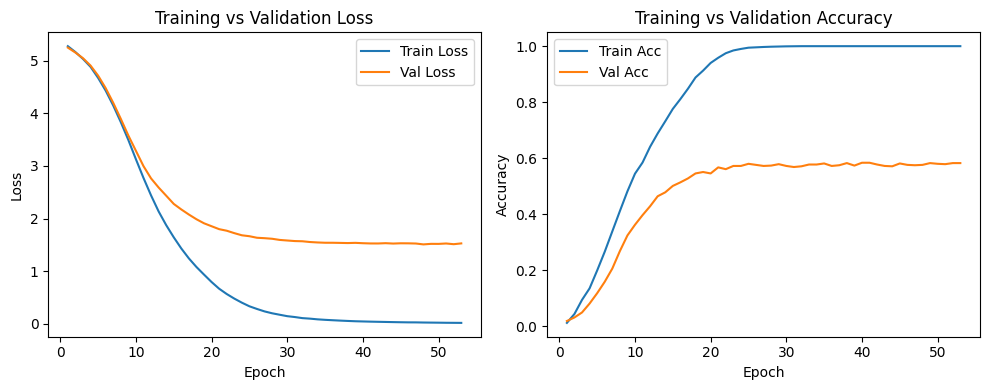

In [24]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

### Predict labels

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------- Load model -------------------
model = timm.create_model("resnet50.a1_in1k", pretrained=False)

num_features = model.get_classifier().in_features
model.fc = nn.Linear(num_features, 200)

model.load_state_dict(torch.load("best_resnet50_2nd_trial.pt", map_location=device))

model = model.to(device)
model.eval()

test_df = pd.read_csv("data/test_images_path.csv")
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))

# Dataset and loader
test_dataset = BirdsDataset(test_df, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ------------------- Predict -------------------
predictions = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

# Convert 0–199 → 1–200
test_df["label"] = [p + 1 for p in predictions]
test_df = test_df[['id','label']]
test_df.to_csv("resnet_50_2.csv", index=False)
print("Saved submissions!")

Saved submission.csv!


# Introduce attributes information to ResNet 50

In [19]:
# birds_df: (200, 313) with class_id + attributes
attr_tensor = torch.tensor(
    birds_df.drop(columns=["class_id", 'class']).values,
    dtype=torch.float32
).to(device)   # shape: [200, 312]

In [20]:
class ResNetWithAttributes(nn.Module):
    def __init__(self, num_classes=200, emb_dim=512):
        super().__init__()
        
        self.backbone = timm.create_model(
            "resnet50.a1_in1k", pretrained=True, num_classes=0
        )

        self.embed = nn.Linear(self.backbone.num_features, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        feat = self.backbone(x)
        emb = self.embed(feat)
        logits = self.classifier(emb)
        return logits, emb

In [21]:
ResNet_model = ResNetWithAttributes(num_classes=200, emb_dim=512).to(device)

In [22]:
attr_proj = nn.Linear(312, 512).to(device)
criterion_cls = nn.CrossEntropyLoss()
criterion_attr = nn.MSELoss()

lambda_attr = 0.2   # weight for attribute alignment

In [23]:
for param in ResNet_model.parameters():
    param.requires_grad = False

for param in ResNet_model.classifier.parameters():
    param.requires_grad = True

for param in ResNet_model.embed.parameters():
    param.requires_grad = True

In [24]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad,
           list(ResNet_model.parameters()) + list(attr_proj.parameters())),
    lr=1e-4,
    weight_decay=1e-4
)

In [25]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits, img_emb = model(images)

        # ---- classification loss ----
        loss_cls = criterion_cls(logits, labels)

        # ---- attribute alignment loss ----
        class_attrs = attr_tensor[labels]        # [B, 312]
        attr_emb = attr_proj(class_attrs)        # [B, 512]
        loss_attr = criterion_attr(img_emb, attr_emb)

        loss = loss_cls + lambda_attr * loss_attr
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total


In [26]:
def evaluate(model, loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits, _ = model(images)

            loss = criterion_cls(logits, labels)

            total_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

In [27]:
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # UNFREEZE AFTER 3 EPOCHS
    if epoch == 4:
        print("Unfreezing entire ResNet50")
        print('\n')
        for param in ResNet_model.parameters():
            param.requires_grad = True

        # IMPORTANT: include attr_proj parameters
        optimizer = torch.optim.AdamW(
            list(ResNet_model.parameters()) + list(attr_proj.parameters()),
            lr=5e-5,          # safer after unfreezing
            weight_decay=1e-4
        )

    # TRAIN
    train_loss, train_acc = train_one_epoch(
        ResNet_model,
        train_loader,
        optimizer,
        device
    )

    # VALIDATION
    val_loss, val_acc = evaluate(
        ResNet_model,
        val_loader,
        device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # EARLY STOPPING (VAL LOSS)
    early_stopping(val_loss, ResNet_model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    # SAVE BEST MODEL (VAL ACC)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model": ResNet_model.state_dict(),
            "attr_proj": attr_proj.state_dict()
        }, "best_resnet50_attr.pt")

        print(f"✅ New best model saved | val_acc = {best_val_acc:.4f}")



Epoch 1/60


100%|██████████| 25/25 [00:04<00:00,  6.08it/s]


  Train | loss: 5.2794, acc: 0.0150
  Val   | loss: 5.2481, acc: 0.0229
Validation loss decreased (inf → 5.248120). Saving model...
✅ New best model saved | val_acc = 0.0229

Epoch 2/60


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


  Train | loss: 5.2011, acc: 0.0341
  Val   | loss: 5.1777, acc: 0.0369
Validation loss decreased (5.248120 → 5.177688). Saving model...
✅ New best model saved | val_acc = 0.0369

Epoch 3/60


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


  Train | loss: 5.1266, acc: 0.0653
  Val   | loss: 5.1167, acc: 0.0802
Validation loss decreased (5.177688 → 5.116675). Saving model...
✅ New best model saved | val_acc = 0.0802

Epoch 4/60
Unfreezing entire ResNet50


100%|██████████| 25/25 [00:09<00:00,  2.66it/s]


  Train | loss: 5.0495, acc: 0.0876
  Val   | loss: 5.0387, acc: 0.0789
Validation loss decreased (5.116675 → 5.038713). Saving model...

Epoch 5/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 4.9463, acc: 0.1188
  Val   | loss: 4.9507, acc: 0.1018
Validation loss decreased (5.038713 → 4.950665). Saving model...
✅ New best model saved | val_acc = 0.1018

Epoch 6/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 4.8247, acc: 0.1500
  Val   | loss: 4.8281, acc: 0.1260
Validation loss decreased (4.950665 → 4.828150). Saving model...
✅ New best model saved | val_acc = 0.1260

Epoch 7/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 4.6690, acc: 0.1904
  Val   | loss: 4.6690, acc: 0.1349
Validation loss decreased (4.828150 → 4.669024). Saving model...
✅ New best model saved | val_acc = 0.1349

Epoch 8/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 4.4779, acc: 0.2261
  Val   | loss: 4.4698, acc: 0.1768
Validation loss decreased (4.669024 → 4.469843). Saving model...
✅ New best model saved | val_acc = 0.1768

Epoch 9/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 4.2556, acc: 0.2726
  Val   | loss: 4.2392, acc: 0.2023
Validation loss decreased (4.469843 → 4.239226). Saving model...
✅ New best model saved | val_acc = 0.2023

Epoch 10/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 3.9919, acc: 0.3134
  Val   | loss: 3.9664, acc: 0.2316
Validation loss decreased (4.239226 → 3.966362). Saving model...
✅ New best model saved | val_acc = 0.2316

Epoch 11/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 3.7215, acc: 0.3452
  Val   | loss: 3.6937, acc: 0.2697
Validation loss decreased (3.966362 → 3.693709). Saving model...
✅ New best model saved | val_acc = 0.2697

Epoch 12/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 3.4341, acc: 0.3971
  Val   | loss: 3.4319, acc: 0.3053
Validation loss decreased (3.693709 → 3.431940). Saving model...
✅ New best model saved | val_acc = 0.3053

Epoch 13/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 3.1549, acc: 0.4373
  Val   | loss: 3.1775, acc: 0.3435
Validation loss decreased (3.431940 → 3.177483). Saving model...
✅ New best model saved | val_acc = 0.3435

Epoch 14/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 2.8984, acc: 0.4758
  Val   | loss: 2.9682, acc: 0.3588
Validation loss decreased (3.177483 → 2.968163). Saving model...
✅ New best model saved | val_acc = 0.3588

Epoch 15/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 2.6628, acc: 0.5159
  Val   | loss: 2.7727, acc: 0.3855
Validation loss decreased (2.968163 → 2.772697). Saving model...
✅ New best model saved | val_acc = 0.3855

Epoch 16/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 2.4487, acc: 0.5529
  Val   | loss: 2.6167, acc: 0.4224
Validation loss decreased (2.772697 → 2.616737). Saving model...
✅ New best model saved | val_acc = 0.4224

Epoch 17/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 2.2457, acc: 0.5946
  Val   | loss: 2.4745, acc: 0.4389
Validation loss decreased (2.616737 → 2.474453). Saving model...
✅ New best model saved | val_acc = 0.4389

Epoch 18/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 2.0779, acc: 0.6350
  Val   | loss: 2.3670, acc: 0.4555
Validation loss decreased (2.474453 → 2.366972). Saving model...
✅ New best model saved | val_acc = 0.4555

Epoch 19/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 1.9217, acc: 0.6640
  Val   | loss: 2.2625, acc: 0.4707
Validation loss decreased (2.366972 → 2.262540). Saving model...
✅ New best model saved | val_acc = 0.4707

Epoch 20/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 1.7853, acc: 0.7051
  Val   | loss: 2.1700, acc: 0.4860
Validation loss decreased (2.262540 → 2.170000). Saving model...
✅ New best model saved | val_acc = 0.4860

Epoch 21/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 1.6556, acc: 0.7354
  Val   | loss: 2.0809, acc: 0.5064
Validation loss decreased (2.170000 → 2.080948). Saving model...
✅ New best model saved | val_acc = 0.5064

Epoch 22/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.5434, acc: 0.7589
  Val   | loss: 2.0216, acc: 0.5115
Validation loss decreased (2.080948 → 2.021586). Saving model...
✅ New best model saved | val_acc = 0.5115

Epoch 23/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.4331, acc: 0.7838
  Val   | loss: 1.9571, acc: 0.5369
Validation loss decreased (2.021586 → 1.957086). Saving model...
✅ New best model saved | val_acc = 0.5369

Epoch 24/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 1.3277, acc: 0.8096
  Val   | loss: 1.9002, acc: 0.5356
Validation loss decreased (1.957086 → 1.900216). Saving model...

Epoch 25/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.2356, acc: 0.8411
  Val   | loss: 1.8500, acc: 0.5356
Validation loss decreased (1.900216 → 1.850000). Saving model...

Epoch 26/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 1.1533, acc: 0.8570
  Val   | loss: 1.8206, acc: 0.5407
Validation loss decreased (1.850000 → 1.820582). Saving model...
✅ New best model saved | val_acc = 0.5407

Epoch 27/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 1.0651, acc: 0.8790
  Val   | loss: 1.7776, acc: 0.5483
Validation loss decreased (1.820582 → 1.777557). Saving model...
✅ New best model saved | val_acc = 0.5483

Epoch 28/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.9894, acc: 0.9025
  Val   | loss: 1.7446, acc: 0.5560
Validation loss decreased (1.777557 → 1.744634). Saving model...
✅ New best model saved | val_acc = 0.5560

Epoch 29/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.9127, acc: 0.9143
  Val   | loss: 1.7135, acc: 0.5585
Validation loss decreased (1.744634 → 1.713499). Saving model...
✅ New best model saved | val_acc = 0.5585

Epoch 30/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.8439, acc: 0.9322
  Val   | loss: 1.6989, acc: 0.5674
Validation loss decreased (1.713499 → 1.698884). Saving model...
✅ New best model saved | val_acc = 0.5674

Epoch 31/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.7926, acc: 0.9459
  Val   | loss: 1.6775, acc: 0.5725
Validation loss decreased (1.698884 → 1.677539). Saving model...
✅ New best model saved | val_acc = 0.5725

Epoch 32/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.7315, acc: 0.9573
  Val   | loss: 1.6568, acc: 0.5725
Validation loss decreased (1.677539 → 1.656789). Saving model...

Epoch 33/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.6832, acc: 0.9621
  Val   | loss: 1.6328, acc: 0.5763
Validation loss decreased (1.656789 → 1.632769). Saving model...
✅ New best model saved | val_acc = 0.5763

Epoch 34/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.6333, acc: 0.9752
  Val   | loss: 1.6428, acc: 0.5700
EarlyStopping counter: 1/5

Epoch 35/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.5947, acc: 0.9787
  Val   | loss: 1.6268, acc: 0.5751
Validation loss decreased (1.632769 → 1.626816). Saving model...

Epoch 36/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.5560, acc: 0.9844
  Val   | loss: 1.6102, acc: 0.5814
Validation loss decreased (1.626816 → 1.610211). Saving model...
✅ New best model saved | val_acc = 0.5814

Epoch 37/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.5165, acc: 0.9869
  Val   | loss: 1.6025, acc: 0.5802
Validation loss decreased (1.610211 → 1.602531). Saving model...

Epoch 38/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.4848, acc: 0.9920
  Val   | loss: 1.5997, acc: 0.5827
Validation loss decreased (1.602531 → 1.599685). Saving model...
✅ New best model saved | val_acc = 0.5827

Epoch 39/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.4593, acc: 0.9908
  Val   | loss: 1.6042, acc: 0.5814
EarlyStopping counter: 1/5

Epoch 40/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.4295, acc: 0.9962
  Val   | loss: 1.6013, acc: 0.5814
EarlyStopping counter: 2/5

Epoch 41/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.4046, acc: 0.9962
  Val   | loss: 1.5905, acc: 0.5802
Validation loss decreased (1.599685 → 1.590486). Saving model...

Epoch 42/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3844, acc: 0.9971
  Val   | loss: 1.5856, acc: 0.5789
Validation loss decreased (1.590486 → 1.585562). Saving model...

Epoch 43/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3673, acc: 0.9978
  Val   | loss: 1.5976, acc: 0.5776
EarlyStopping counter: 1/5

Epoch 44/60


100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


  Train | loss: 0.3508, acc: 0.9981
  Val   | loss: 1.5921, acc: 0.5814
EarlyStopping counter: 2/5

Epoch 45/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3358, acc: 0.9990
  Val   | loss: 1.5947, acc: 0.5852
EarlyStopping counter: 3/5
✅ New best model saved | val_acc = 0.5852

Epoch 46/60


100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


  Train | loss: 0.3193, acc: 0.9990
  Val   | loss: 1.6005, acc: 0.5789
EarlyStopping counter: 4/5

Epoch 47/60


100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


  Train | loss: 0.3064, acc: 0.9990
  Val   | loss: 1.6021, acc: 0.5852
EarlyStopping counter: 5/5
Early stopping triggered!


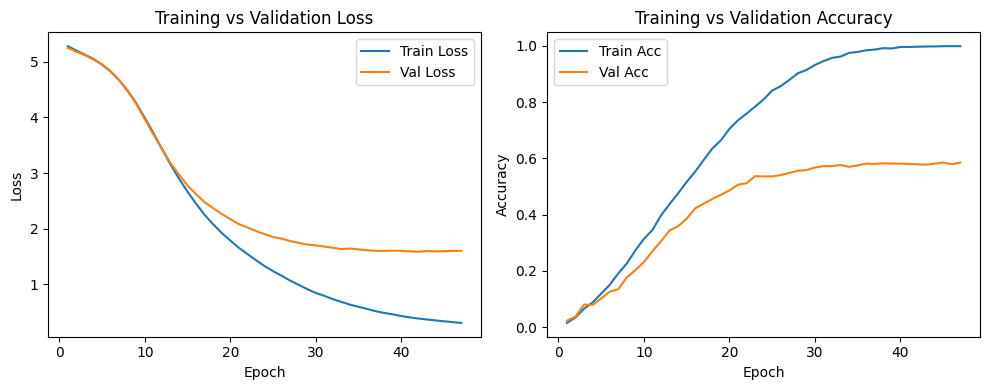

In [28]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

In [30]:
# ------------------- Load model -------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint = torch.load("best_resnet50_attr.pt", map_location=device)

model = ResNetWithAttributes(num_classes=200, emb_dim=512).to(device)
model.load_state_dict(checkpoint["model"])

model.eval()

test_df = pd.read_csv("data/test_images_path.csv")
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))

# Dataset and loader
test_dataset = BirdsDataset(test_df, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ------------------- Predict -------------------
predictions = []
with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        logits, _ = model(imgs)   #unpack tuple
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())

# Convert 0–199 → 1–200
test_df["label"] = [p + 1 for p in predictions]
test_df = test_df[['id','label']]
test_df.to_csv("resnet_50_2_at.csv", index=False)
print("Saved submissions!")

Saved submissions!


## Bird-species classifier pretrained model
[https://huggingface.co/ozzyonfire/bird-species-classifier]

In [46]:
from transformers import (AutoImageProcessor, AutoModelForImageClassification)
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoImageProcessor.from_pretrained("chriamue/bird-species-classifier")
model = AutoModelForImageClassification.from_pretrained("chriamue/bird-species-classifier", num_labels=200, ignore_mismatched_sizes=True).to(device)

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at chriamue/bird-species-classifier and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([525]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([525, 1408]) in the checkpoint and torch.Size([200, 1408]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 200).to(device)

In [48]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4, weight_decay=1e-4)

In [47]:
class BirdsDatasetHF(Dataset):
    def __init__(self, df, processor, is_test=False):
        self.df = df
        self.processor = processor
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        image = Image.open(img_path).convert("RGB")

        inputs = self.processor(image, return_tensors="pt")

        pixel_values = inputs["pixel_values"].squeeze(0)

        if self.is_test:
            return pixel_values

        label = self.df.iloc[idx]["label"] - 1
        return pixel_values, label

In [48]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=images)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=images)
            logits = outputs.logits

            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

In [52]:
# early_stopping already defined earlier
early_stopping = EarlyStopping(patience=5, min_delta=0.001, verbose=True)
num_epochs = 60
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")

    # Unfreeze network after 3 epochs
    if epoch == 4:
        print("Unfreezing entire EfficientNet / HF model")
        for param in model.parameters():
            param.requires_grad = True

        # When you unfreeze, RECREATE optimizer to include all params
        # Use a smaller lr after unfreezing
        optimizer = torch.optim.AdamW(
            list(model.parameters()),
            lr=3e-5,
            weight_decay=1e-4
        )

    # TRAIN
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # VALIDATION
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    # LOGGING
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # EARLY STOPPING (on validation loss)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print(f"  Train | loss: {train_loss:.4f}, acc: {train_acc:.4f}")
    print(f"  Val   | loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # SAVE BEST MODEL (BY VAL ACC)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc
        }, "best_bird_classifier.pt")
        print(f"New best model saved with val_acc = {best_val_acc:.4f}")



Epoch 1/60


100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


Validation loss decreased (inf → 4.893877). Saving model...
  Train | loss: 5.0776, acc: 0.0389
  Val   | loss: 4.8939, acc: 0.0980
New best model saved with val_acc = 0.0980

Epoch 2/60


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


Validation loss decreased (4.893877 → 4.594168). Saving model...
  Train | loss: 4.3793, acc: 0.2153
  Val   | loss: 4.5942, acc: 0.2036
New best model saved with val_acc = 0.2036

Epoch 3/60


100%|██████████| 13/13 [00:00<00:00, 14.88it/s]


Validation loss decreased (4.594168 → 4.355134). Saving model...
  Train | loss: 3.8074, acc: 0.3739
  Val   | loss: 4.3551, acc: 0.2926
New best model saved with val_acc = 0.2926

Epoch 4/60
Unfreezing entire EfficientNet / HF model


100%|██████████| 13/13 [00:00<00:00, 14.61it/s]


Validation loss decreased (4.355134 → 4.068440). Saving model...
  Train | loss: 3.3076, acc: 0.4717
  Val   | loss: 4.0684, acc: 0.3333
New best model saved with val_acc = 0.3333

Epoch 5/60


100%|██████████| 13/13 [00:00<00:00, 14.89it/s]


EarlyStopping counter: 1/5
  Train | loss: 2.8425, acc: 0.5439
  Val   | loss: 5.0985, acc: 0.4466
New best model saved with val_acc = 0.4466

Epoch 6/60


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


Validation loss decreased (4.068440 → 3.474242). Saving model...
  Train | loss: 2.5131, acc: 0.5917
  Val   | loss: 3.4742, acc: 0.4237

Epoch 7/60


100%|██████████| 13/13 [00:00<00:00, 14.70it/s]


Validation loss decreased (3.474242 → 2.948560). Saving model...
  Train | loss: 2.2310, acc: 0.6433
  Val   | loss: 2.9486, acc: 0.4733
New best model saved with val_acc = 0.4733

Epoch 8/60


100%|██████████| 13/13 [00:00<00:00, 14.67it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.9891, acc: 0.6752
  Val   | loss: 3.0009, acc: 0.4046

Epoch 9/60


100%|██████████| 13/13 [00:00<00:00, 14.55it/s]


Validation loss decreased (2.948560 → 2.604794). Saving model...
  Train | loss: 1.7992, acc: 0.7096
  Val   | loss: 2.6048, acc: 0.5038
New best model saved with val_acc = 0.5038

Epoch 10/60


100%|██████████| 13/13 [00:00<00:00, 14.47it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.6279, acc: 0.7471
  Val   | loss: 2.6080, acc: 0.5394
New best model saved with val_acc = 0.5394

Epoch 11/60


100%|██████████| 13/13 [00:00<00:00, 14.93it/s]


Validation loss decreased (2.604794 → 2.588290). Saving model...
  Train | loss: 1.4858, acc: 0.7774
  Val   | loss: 2.5883, acc: 0.5305

Epoch 12/60


100%|██████████| 13/13 [00:00<00:00, 15.00it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.3586, acc: 0.8029
  Val   | loss: 2.5946, acc: 0.5229

Epoch 13/60


100%|██████████| 13/13 [00:00<00:00, 14.75it/s]


EarlyStopping counter: 2/5
  Train | loss: 1.2122, acc: 0.8344
  Val   | loss: 10.3233, acc: 0.5458
New best model saved with val_acc = 0.5458

Epoch 14/60


100%|██████████| 13/13 [00:00<00:00, 14.42it/s]


Validation loss decreased (2.588290 → 2.205286). Saving model...
  Train | loss: 1.1282, acc: 0.8583
  Val   | loss: 2.2053, acc: 0.5471
New best model saved with val_acc = 0.5471

Epoch 15/60


100%|██████████| 13/13 [00:00<00:00, 14.86it/s]


EarlyStopping counter: 1/5
  Train | loss: 1.0168, acc: 0.8694
  Val   | loss: 2.4598, acc: 0.5013

Epoch 16/60


100%|██████████| 13/13 [00:00<00:00, 14.62it/s]


EarlyStopping counter: 2/5
  Train | loss: 0.9160, acc: 0.8939
  Val   | loss: 2.3585, acc: 0.5178

Epoch 17/60


100%|██████████| 13/13 [00:00<00:00, 14.80it/s]


Validation loss decreased (2.205286 → 2.144846). Saving model...
  Train | loss: 0.8257, acc: 0.9146
  Val   | loss: 2.1448, acc: 0.5623
New best model saved with val_acc = 0.5623

Epoch 18/60


100%|██████████| 13/13 [00:00<00:00, 14.78it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.7625, acc: 0.9264
  Val   | loss: 2.3087, acc: 0.5165

Epoch 19/60


100%|██████████| 13/13 [00:00<00:00, 14.51it/s]


Validation loss decreased (2.144846 → 2.018124). Saving model...
  Train | loss: 0.6831, acc: 0.9347
  Val   | loss: 2.0181, acc: 0.5980
New best model saved with val_acc = 0.5980

Epoch 20/60


100%|██████████| 13/13 [00:00<00:00, 14.62it/s]


Validation loss decreased (2.018124 → 1.967162). Saving model...
  Train | loss: 0.6060, acc: 0.9459
  Val   | loss: 1.9672, acc: 0.5814

Epoch 21/60


100%|██████████| 13/13 [00:00<00:00, 14.92it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.5634, acc: 0.9580
  Val   | loss: 2.1821, acc: 0.5305

Epoch 22/60


100%|██████████| 13/13 [00:00<00:00, 14.86it/s]


Validation loss decreased (1.967162 → 1.907258). Saving model...
  Train | loss: 0.4921, acc: 0.9659
  Val   | loss: 1.9073, acc: 0.5840

Epoch 23/60


100%|██████████| 13/13 [00:00<00:00, 14.93it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.5013, acc: 0.9697
  Val   | loss: 2.1226, acc: 0.5293

Epoch 24/60


100%|██████████| 13/13 [00:00<00:00, 14.87it/s]


EarlyStopping counter: 2/5
  Train | loss: 0.4035, acc: 0.9793
  Val   | loss: 1.9797, acc: 0.5827

Epoch 25/60


100%|██████████| 13/13 [00:00<00:00, 14.57it/s]


EarlyStopping counter: 3/5
  Train | loss: 0.3986, acc: 0.9822
  Val   | loss: 2.1350, acc: 0.5598

Epoch 26/60


100%|██████████| 13/13 [00:00<00:00, 14.85it/s]


EarlyStopping counter: 4/5
  Train | loss: 0.3633, acc: 0.9838
  Val   | loss: 2.0973, acc: 0.5534

Epoch 27/60


100%|██████████| 13/13 [00:00<00:00, 14.54it/s]


Validation loss decreased (1.907258 → 1.747337). Saving model...
  Train | loss: 0.3355, acc: 0.9866
  Val   | loss: 1.7473, acc: 0.5967

Epoch 28/60


100%|██████████| 13/13 [00:00<00:00, 14.78it/s]


EarlyStopping counter: 1/5
  Train | loss: 0.2985, acc: 0.9892
  Val   | loss: 1.9333, acc: 0.5891

Epoch 29/60


100%|██████████| 13/13 [00:00<00:00, 14.52it/s]


EarlyStopping counter: 2/5
  Train | loss: 0.2747, acc: 0.9908
  Val   | loss: 1.8258, acc: 0.6527
New best model saved with val_acc = 0.6527

Epoch 30/60


100%|██████████| 13/13 [00:00<00:00, 14.77it/s]


EarlyStopping counter: 3/5
  Train | loss: 0.2486, acc: 0.9936
  Val   | loss: 2.8885, acc: 0.6145

Epoch 31/60


100%|██████████| 13/13 [00:00<00:00, 14.82it/s]


EarlyStopping counter: 4/5
  Train | loss: 0.2417, acc: 0.9946
  Val   | loss: 245.2552, acc: 0.5827

Epoch 32/60


100%|██████████| 13/13 [00:00<00:00, 14.97it/s]

EarlyStopping counter: 5/5
Early stopping triggered!


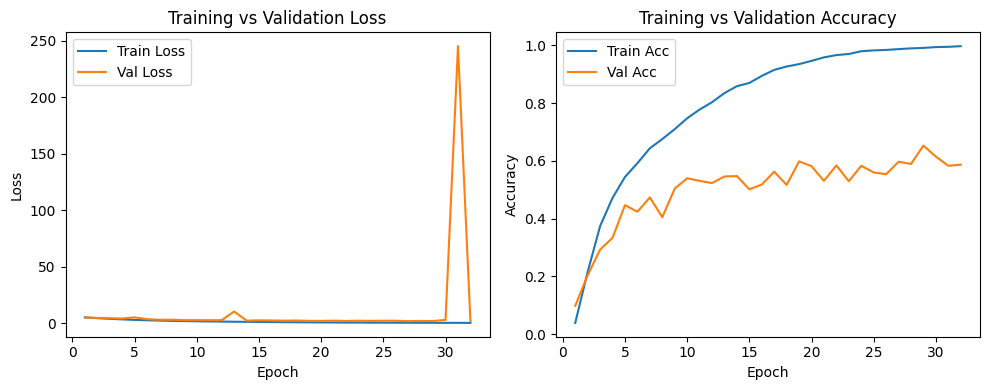

In [57]:
train_val_plot(train_losses, val_losses, train_accs, val_accs)

### Predict labels

In [58]:
test_dataset = BirdsDatasetHF(df=test_df, processor=processor, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_df = pd.read_csv("data/test_images_path.csv")
test_df["image_path"] = test_df["image_path"].apply(lambda x: os.path.join("data", x.lstrip("/")))

# ---- Create dataset + loader ----
test_dataset = BirdsDatasetHF(test_df, processor, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ---- Load best model checkpoint ----
checkpoint = torch.load("best_bird_classifier.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

all_preds = []

with torch.no_grad():
    for pixel_values in test_loader:
        pixel_values = pixel_values.to(device)

        outputs = model(pixel_values)

        # EfficientNet from HF usually returns a ModelOutput with .logits
        logits = outputs.logits if hasattr(outputs, "logits") else outputs
        preds = torch.argmax(logits, dim=1)

        # remember training used (label - 1)
        preds = preds.cpu().numpy() + 1  

        all_preds.extend(preds)

# ---- Save predictions ----
test_df["label"] = all_preds
test_df[['id','label']].to_csv("bird_classifier2.csv", index=False)

print("Saved predictions to bird_classifier1.csv 👍")

Saved predictions to bird_classifier1.csv 👍
